### Global Warming, Temperature Change, Climate Change (TemperatureChange_ByCountry.csv):

The original datasets WorldTemperatureChange.csv (Environment_Temperature_change_E_All_Data_NOFLAG.csv on Kaggle) shows statistics of mean surface temperature change in every country around the world as well as regional and world data for it. The data is monthly updated from 1961 to 2019. Since the original data contains some unnessesary data, I created a code to first convert the csv file into chosen data only one. The variables are explained below. 


__Date(dt):__ Monthly data, starts in January 1961 to December 2019

__India:__ Average temperature change focusd in Idia

__Japan:__ Average temperature change focusd in Japan

__Netherlands:__ Average temperature change focusd in Netherlands

__World:__ Average temperature change focusd in World

__source:__ https://www.kaggle.com/datasets/sevgisarac/temperature-change

### Project Objectives
__Trend and Comparative Analysis__

Once collecting data, find the trends in temperature change over years in the world. Then, narrow it down into each country data and check if there are significant effects of one country to another. 

__Predictive Modeling__

Utilizing various predicting models to predict the future temperature change. This includes techniques, such as time series analysis, machine learning algorithms, and so on. 

__Model Evaluation and Validation__

After predicting the model with such tequniques, evaluate the quality of those tequniques by using appropriate matrics. 

__Discussion__

After the evaluation and validation, utilize those models and discuss the future climate change as well as provide recommendations for researchers based on the analysis result and predictions. 

### Research Questions
1. What are the trends in temperature change over time?
2. How do the temperature change in one country affects the others?
3. How can the future global warming be predicted based on historical data?

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from ipywidgets import interact, widgets
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

### Conversion Code

The code below is the conversion code from original datasets to one contains chosen data only. The format is also modified based on GlobalTemperatures.csv, which was provided in class as an example. 


When checking, please include GlobalTemperatures.csv from week6 and WorldTemperatureChange.csv into a folder named input_data.
The original file name for the WorldTemperatureChange.csv is Environment_Temperature_change_E_All_Data_NOFLAG.csv

In [4]:
global_temperatures = pd.read_csv('GlobalTemperatures.csv')
world_temperature_change = pd.read_csv('WorldTemperatureChange.csv', encoding='latin1')

countries_of_interest = ['Japan', 'India', 'Netherlands', 'World']
temperature_change_filtered = world_temperature_change[world_temperature_change['Area'].isin(countries_of_interest)]

unnecessary_months = [
    "DecñJanñFeb", "MarñAprñMay", "JunñJulñAug", "SepñOctñNov", "Meteorological year"
]
temperature_change_filtered = temperature_change_filtered[~temperature_change_filtered['Months'].isin(unnecessary_months)]

temperature_change_long = temperature_change_filtered.melt(id_vars=["Area", "Months", "Element"], 
                                                           var_name="Year", 
                                                           value_name="Temperature")

temperature_change_data = temperature_change_long[temperature_change_long["Element"] == "Temperature change"]

temperature_change_data = temperature_change_data.dropna(subset=['Year'])
temperature_change_data['Year'] = temperature_change_data['Year'].str.extract('(\d{4})', expand=False).astype(float)

temperature_change_data = temperature_change_data.dropna(subset=['Year'])
temperature_change_data['Year'] = temperature_change_data['Year'].astype(int)

temperature_change_data['Month'] = temperature_change_data['Months'].map({
    "January": "01", "February": "02", "March": "03", "April": "04",
    "May": "05", "June": "06", "July": "07", "August": "08",
    "September": "09", "October": "10", "November": "11", "December": "12"
})
temperature_change_data['dt'] = temperature_change_data['Year'].astype(str) + '-' + temperature_change_data['Month'] + '-01'

temperature_change_pivot = temperature_change_data.pivot_table(index='dt', columns='Area', values='Temperature', aggfunc='first').reset_index()

temperature_change_pivot.to_csv('TemperatureChange_ByCountry.csv', index=False)

temperature_change_pivot.head()


Area,dt,India,Japan,Netherlands,World
0,1961-01-01,0.536,-0.981,-0.009,0.399
1,1961-02-01,-1.413,-0.628,4.082,0.263
2,1961-03-01,0.499,0.6,2.54,0.254
3,1961-04-01,0.026,0.761,2.735,0.278
4,1961-05-01,-0.144,0.989,-1.141,0.367


In [5]:
# Read the CSV file 'TemperatureChange_ByCountry.csv' into a DataFrame.
# The 'parse_dates' parameter is used to convert the 'dt' column to datetime objects.
# The 'index_col' parameter sets the 'dt' column as the index of the DataFrame.
df = pd.read_csv("TemperatureChange_ByCountry.csv", index_col='dt', parse_dates=True)
# Set the frequency of the DataFrame to the start of the month ('MS').
df = df.asfreq('MS')

In [6]:
df

,India,Japan,Netherlands,World
dt,,,,
1961-01-01,0.536,-0.981,-0.009,0.399
1961-02-01,-1.413,-0.628,4.082,0.263
1961-03-01,0.499,0.600,2.540,0.254
1961-04-01,0.026,0.761,2.735,0.278
1961-05-01,-0.144,0.989,-1.141,0.367
...,...,...,...,...
2019-08-01,0.751,0.903,2.685,1.201
2019-09-01,0.445,1.852,0.767,1.415
2019-10-01,0.267,2.028,1.634,1.545


In [7]:
# Identify columns that contain the word 'Uncertainty' in their name.
uncertainty_columns = df.filter(like='Uncertainty').columns

# Drop the identified uncertainty columns from the DataFrame.
df = df.drop(columns=uncertainty_columns)

In [8]:
df

,India,Japan,Netherlands,World
dt,,,,
1961-01-01,0.536,-0.981,-0.009,0.399
1961-02-01,-1.413,-0.628,4.082,0.263
1961-03-01,0.499,0.600,2.540,0.254
1961-04-01,0.026,0.761,2.735,0.278
1961-05-01,-0.144,0.989,-1.141,0.367
...,...,...,...,...
2019-08-01,0.751,0.903,2.685,1.201
2019-09-01,0.445,1.852,0.767,1.415
2019-10-01,0.267,2.028,1.634,1.545


In [9]:
# Display concise summary information about the DataFrame.
# This includes the index dtype and column dtypes, non-null values, and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708 entries, 1961-01-01 to 2019-12-01
Freq: MS
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   India        708 non-null    float64
 1   Japan        708 non-null    float64
 2   Netherlands  708 non-null    float64
 3   World        708 non-null    float64
dtypes: float64(4)
memory usage: 27.7 KB


In [10]:
# Generate a statistical summary of the numerical columns in the DataFrame
df.describe()

,India,Japan,Netherlands,World
count,708.000000,708.000000,708.000000,708.000000
mean,0.215900,0.320606,0.672929,0.525314
std,0.615372,0.927462,1.753222,0.583313
min,-1.735000,-2.753000,-7.121000,-1.306000
25%,-0.200000,-0.288000,-0.365750,0.089750
50%,0.207500,0.327000,0.634500,0.462000
75%,0.600250,0.984000,1.784250,0.964250
max,2.533000,2.929000,6.179000,2.624000


In [11]:
# Count the number of missing values in each column of the DataFrame
df.isnull().sum()

India          0
Japan          0
Netherlands    0
World          0
dtype: int64

In [12]:
# Filter rows containing all NaN (missing) values
all_nan_rows = df[df.isna().all(axis=1)]
print("Number of rows where all columns are NaN:", len(all_nan_rows))
print(all_nan_rows)

# Interpolate missing values using linear interpolation and modify DataFrame in place
df.interpolate(method='linear', inplace=True)

# Retrieve the dimensions of the DataFrame (number of rows, number of columns)
print(df.shape)

Number of rows where all columns are NaN: 0
Empty DataFrame
Columns: [India, Japan, Netherlands, World]
Index: []
(708, 4)


In [13]:
# Count the number of missing values in each column of the DataFrame
df.isnull().sum()

India          0
Japan          0
Netherlands    0
World          0
dtype: int64

In [14]:
df

,India,Japan,Netherlands,World
dt,,,,
1961-01-01,0.536,-0.981,-0.009,0.399
1961-02-01,-1.413,-0.628,4.082,0.263
1961-03-01,0.499,0.600,2.540,0.254
1961-04-01,0.026,0.761,2.735,0.278
1961-05-01,-0.144,0.989,-1.141,0.367
...,...,...,...,...
2019-08-01,0.751,0.903,2.685,1.201
2019-09-01,0.445,1.852,0.767,1.415
2019-10-01,0.267,2.028,1.634,1.545


In [15]:
# Return the index label of the minimum value for each column in the DataFrame
df.idxmin()

India         1961-12-01
Japan         1970-03-01
Netherlands   1963-01-01
World         1972-02-01
dtype: datetime64[ns]

In [16]:
# Return the index label of the maximum value for each column in the DataFrame
df.idxmax()

India         2006-02-01
Japan         1990-02-01
Netherlands   2015-12-01
World         2016-02-01
dtype: datetime64[ns]

### World Temperature Change Over Time
__Purpose of the Plot__

the below graph is created to identify long-term temperature change patterns

__Interpretation of the Result__

The world temperature change has a clear upward trend. Especially after 200s, the temperature rise becomes more radically.

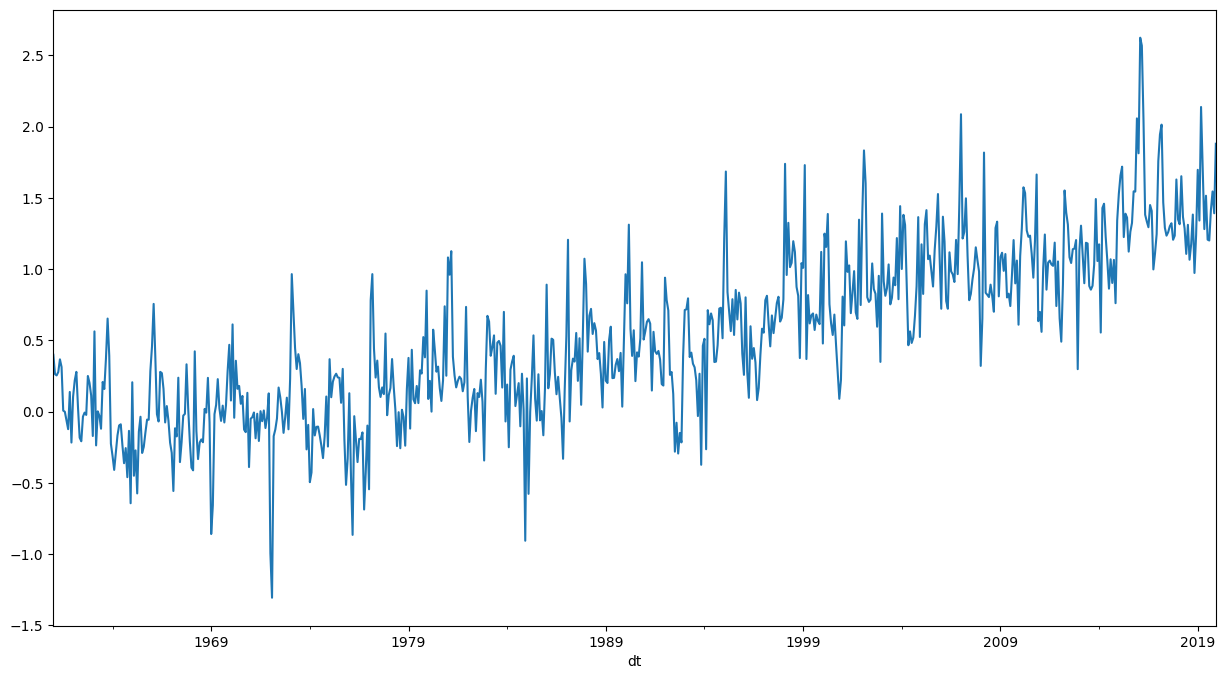

In [17]:
# Plot the 'World' column from the DataFrame
# Set the figure size to (15, 8) for better visualization
df.World.plot(figsize=(15, 8));

### Recent World Temperature Change
__Purpose of the Plot__

This plot focuses on the recent 200 months to highlight short-term temperature trends.

__Interpretation of the Result__

The recent data shows the gradual rise of the world temperature, reinforcing the ongoing trend of global warming.

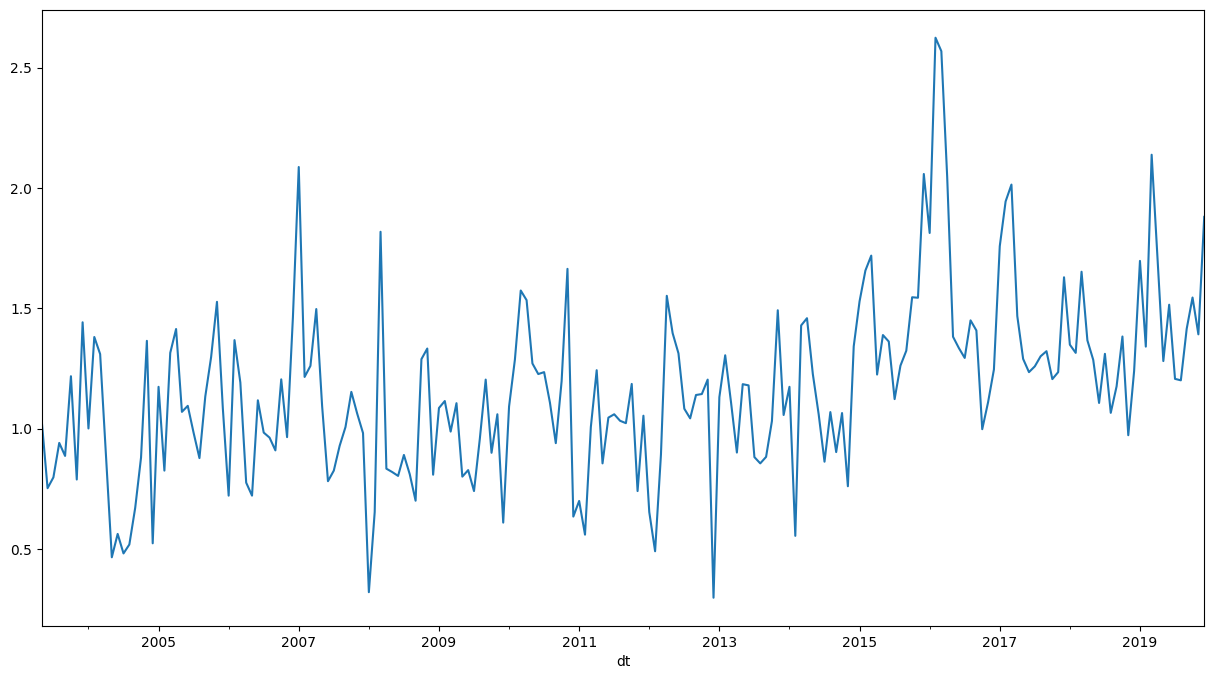

In [18]:
# Plot the 'LandAverageTemperature' column from the last 200 rows of the DataFrame
# Set the figure size to (15, 8) for better visualization
df.World[-200:].plot(figsize=(15, 8));

### World Temperature Change with 5-Year Moving Average
__Purpose of the Plot__

This plot uses a 5-year moving average to smooth out short-term variations and make longer-term temperature trends easier to recognize.

__Interpretation of the Result__

The smoothed data confirms the upward trend in global temperatures, making the long-term increase clearer.

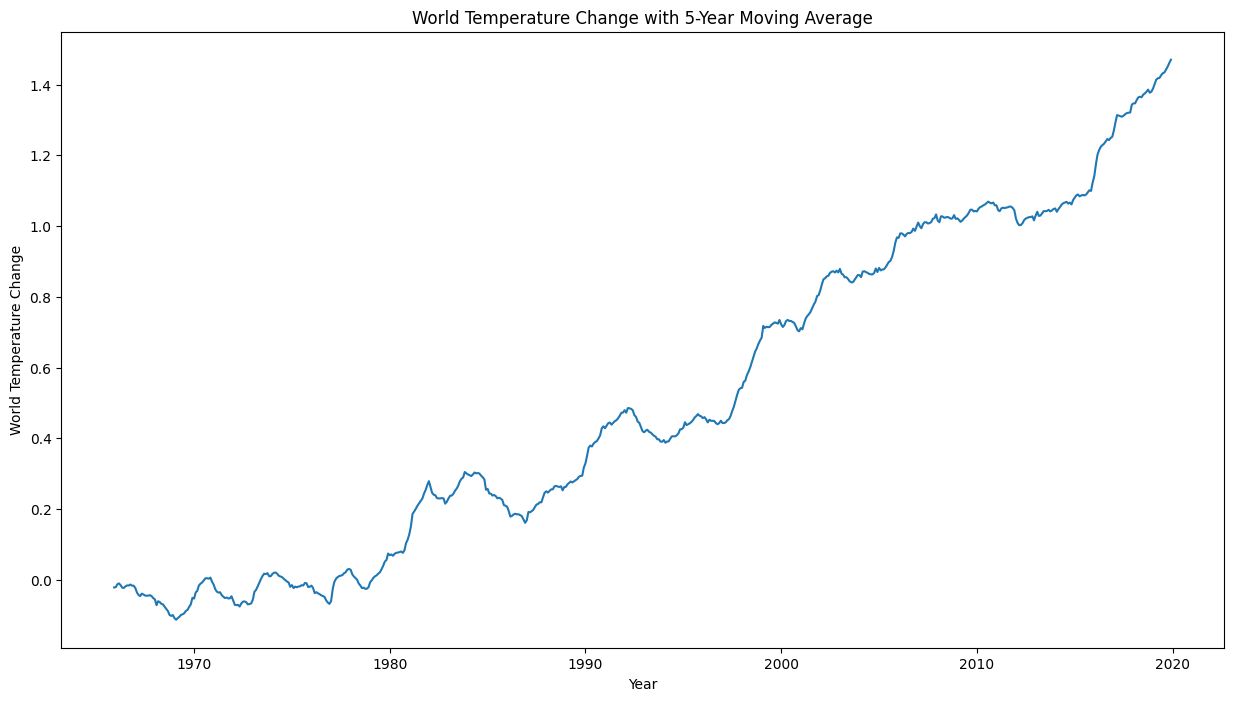

In [19]:
# Set the figure size for the plot
plt.figure(figsize=(15, 8))

# Calculate the 5-year rolling mean
rolling_mean = df['World'].rolling(window=60).mean()

# Plot the 5-year moving average
plt.plot(rolling_mean.index, rolling_mean, label='5-Year Moving Average')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('World Temperature Change')
plt.title('World Temperature Change with 5-Year Moving Average')

# Display the plot
plt.show()

In [20]:
# Print the index of the lowest value
print("Index of the lowest value:", rolling_mean.idxmin())

Index of the lowest value: 1969-02-01 00:00:00


### World Temperature Change with Expanding Average
__Purpose of the Plot__

This plot uses the expanding average to show the cumulative trend of temperature change over time.

__Interpretation of the Result__

The expanding average makes the sustained increase in temperatures more recognizable, emphasizing the long-term impact of global warming.

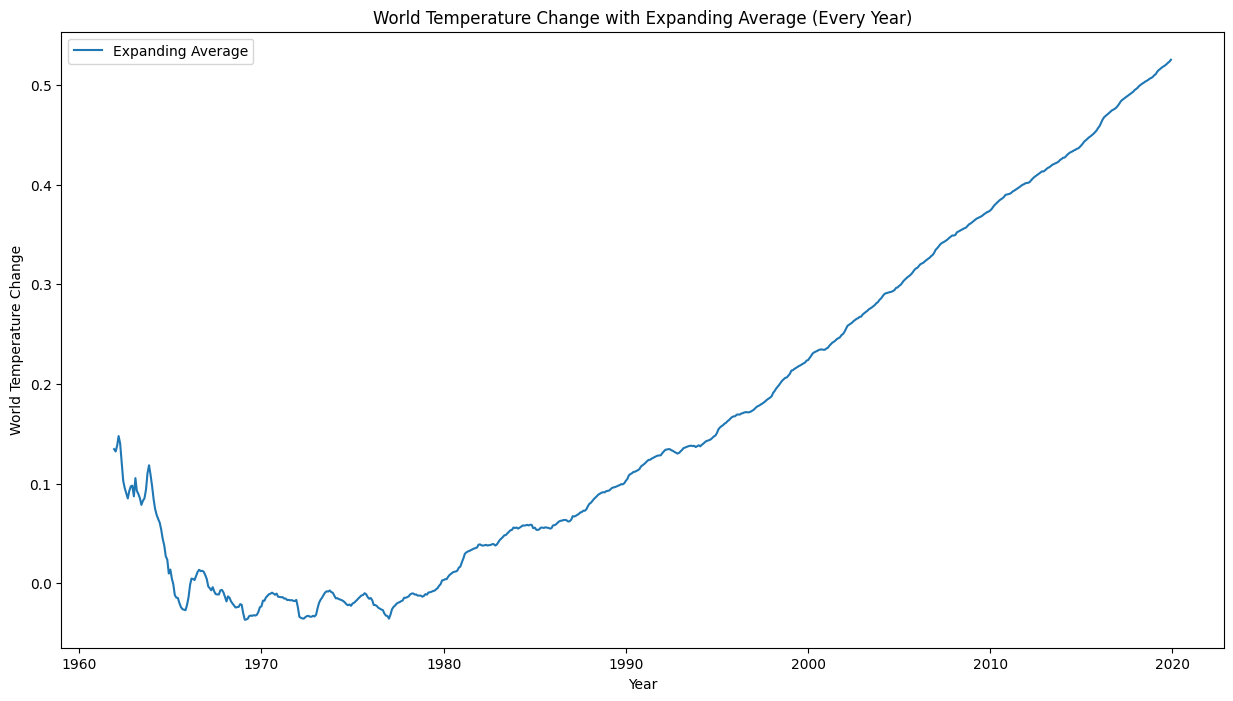

In [21]:
# Compute the expanding mean (cumulative mean) with a minimum number of observations equal to 12 months (1 year)
expanding_mean = df['World'].expanding(12).mean()

# Plot the expanding mean
plt.figure(figsize=(15, 8))
plt.plot(expanding_mean.index, expanding_mean, label='Expanding Average')
plt.xlabel('Year')
plt.ylabel('World Temperature Change')
plt.title('World Temperature Change with Expanding Average (Every Year)')
plt.legend()
plt.show()

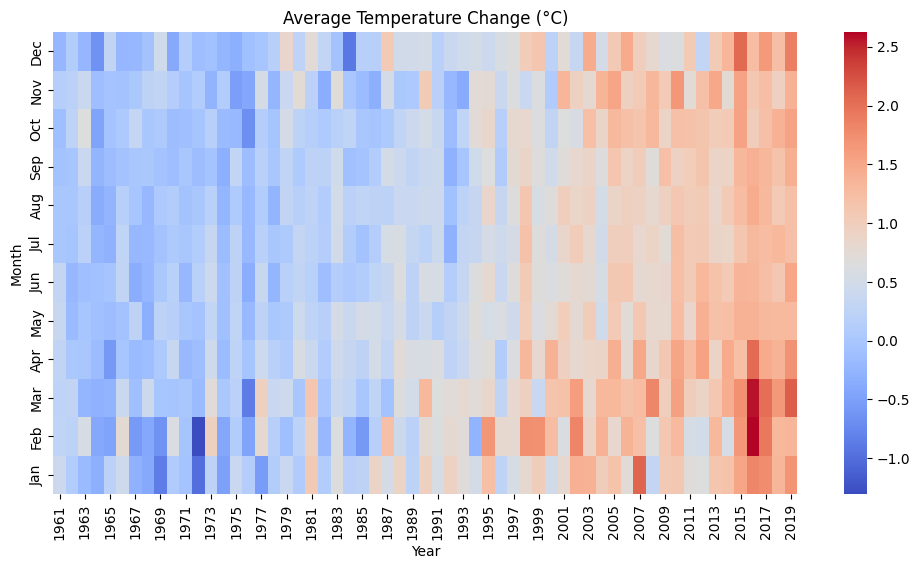

In [22]:
# Add 'Year' and 'Month' columns to the DataFrame
df['Year'] = df.index.year
df['Month'] = df.index.month

# Pivot the DataFrame to have years as columns and months as rows
pivot_df = df.pivot_table(index='Month', columns='Year', values='World')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df[::-1], cmap='coolwarm', annot=False, yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][::-1])
plt.title('Average Temperature Change (°C)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

# Drop the 'Year' and 'Month' columns from the DataFrame
df.drop('Year', axis=1, inplace=True)
df.drop('Month', axis=1, inplace=True)

### Scatterplots comparing a country to another

__Purpose of the Result__
This plot focuses on the correlation of each country's temperature change, and analyze if one affects another. 

__Interpretation of the Result__
All correlation coefficients are below 0.25, so there are no correlation among countries. Therefore, the temperature change is occuring world wide. 

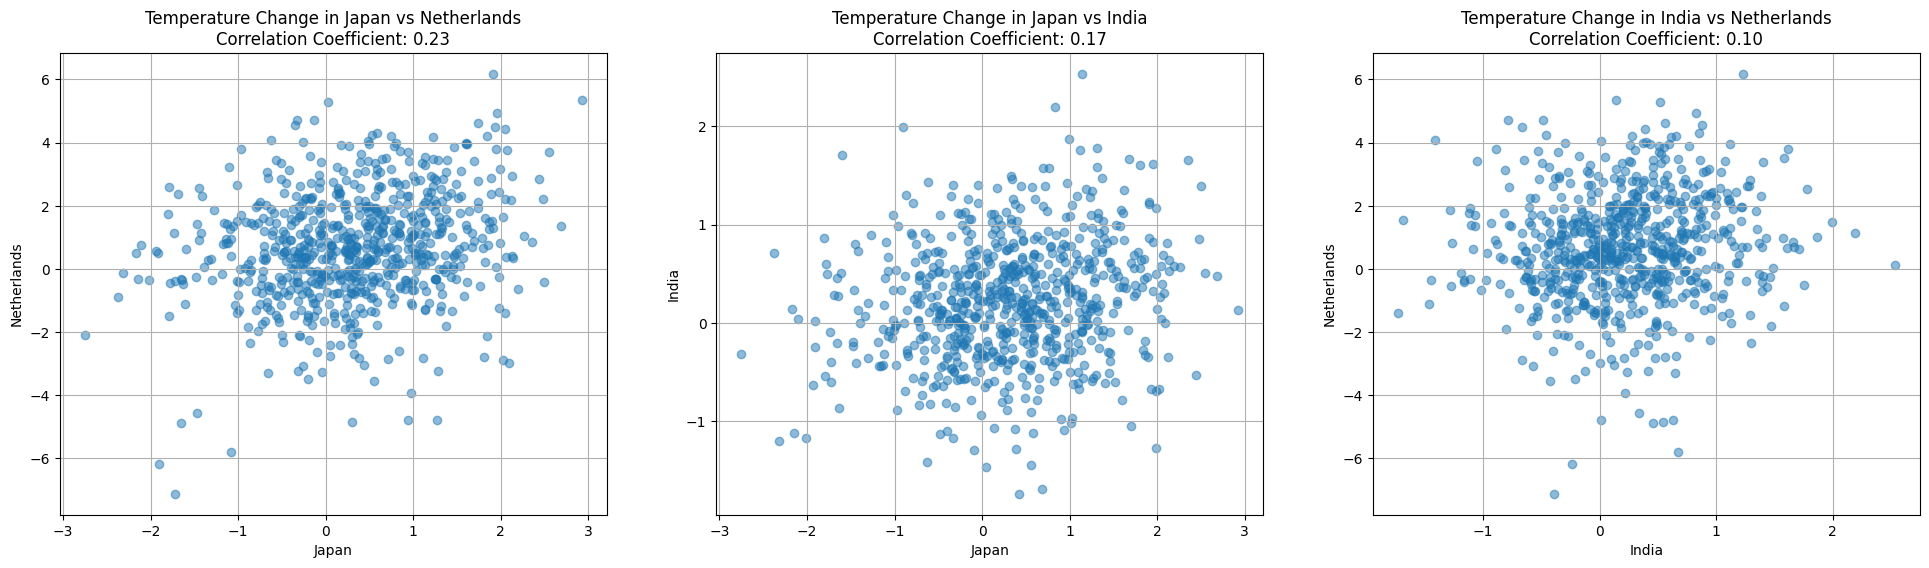

In [23]:
corr_japan_netherlands = df['Japan'].corr(df['Netherlands'])
corr_japan_india = df['Japan'].corr(df['India'])
corr_india_netherlands = df['India'].corr(df['Netherlands'])

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].scatter(df['Japan'], df['Netherlands'], alpha=0.5)
axs[0].set_title(f'Temperature Change in Japan vs Netherlands\nCorrelation Coefficient: {corr_japan_netherlands:.2f}')
axs[0].set_xlabel('Japan')
axs[0].set_ylabel('Netherlands')
axs[0].grid(True)

axs[1].scatter(df['Japan'], df['India'], alpha=0.5)
axs[1].set_title(f'Temperature Change in Japan vs India\nCorrelation Coefficient: {corr_japan_india:.2f}')
axs[1].set_xlabel('Japan')
axs[1].set_ylabel('India')
axs[1].grid(True)

axs[2].scatter(df['India'], df['Netherlands'], alpha=0.5)
axs[2].set_title(f'Temperature Change in India vs Netherlands\nCorrelation Coefficient: {corr_india_netherlands:.2f}')
axs[2].set_xlabel('India')
axs[2].set_ylabel('Netherlands')
axs[2].grid(True)

plt.show()

In [24]:
# Compute the correlation matrix for the DataFrame
df.corr()

,India,Japan,Netherlands,World
India,1.000000,0.174565,0.098756,0.456622
Japan,0.174565,1.000000,0.229768,0.406911
Netherlands,0.098756,0.229768,1.000000,0.375191
World,0.456622,0.406911,0.375191,1.000000


In [25]:
df.corr().sum()

India          1.729942
Japan          1.811244
Netherlands    1.703714
World          2.238724
dtype: float64

### Autocorrelation Plot

__Purpose__

the purpose is to visualize the autocorrelation of the world temperature change data over different lags. Autocorrelation measures the correlation of the time series with a lagged version of itself.

__Interpretation of the Result__

The autocorrelation plot shows significant autocorrelation for many lags, which indicates that previous values affect future values over a long period. This strong autocorrelation suggests that there are seasonality or long-term trends in the temperature change data.

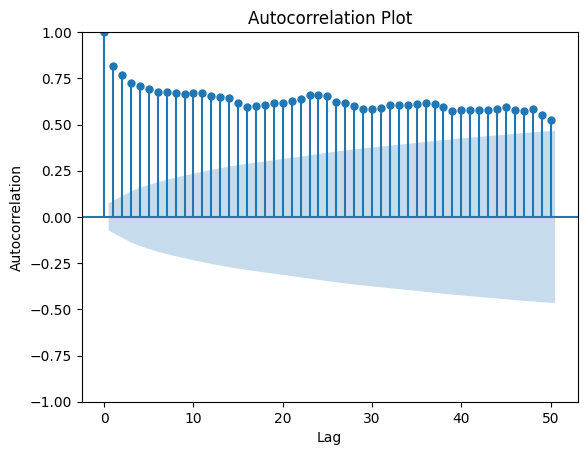

In [26]:
# Create autocorrelation plot
plot_acf(df.World, lags=50) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

### Classical Decomposition and Seasonal-Trend decomposition

__Purpose of the Plot__

These models decompose world temperature change data into trend, seasonal, and residual components using Classical Decomposition and Seasonal-Trend decomposition using Loess (STL).

__Interpretation of the Result__

_Classical Decomposition:_

Trend: Shows long-term upward trend
Seasonal: Shows a regular annual pattern.
Residual: Residuals are centered around zero, which indicate the model captures trend and seasonality well.

_STL Decomposition:_

Trend: Shows an upward trend.
Seasonal: Shows a more flexible pattern.
Residual: Residuals are more stable, suggesting STL better captures data patterns.

_Overall:_

Both methods confirm the upward temperature trend and significant seasonality, with STL providing more detailed seasonal patterns and stable residuals.

In [27]:
# Perform classical decomposition of the 'LandAverageTemperature' column
classical_decomposition = seasonal_decompose(df.World, model='additive', period=12)

# Extract components: trend, seasonal, and residual
classical_trend = classical_decomposition.trend
classical_seasonal = classical_decomposition.seasonal
classical_residual = classical_decomposition.resid

In [28]:
# Perform Seasonal-Trend decomposition using Loess (STL) on the 'LandAverageTemperature' column
stl = STL(df.World)

# Fit the STL decomposition model
stl_result = stl.fit()

# Extract components: trend, seasonal, and residual
stl_trend = stl_result.trend
stl_seasonal = stl_result.seasonal
stl_residual = stl_result.resid

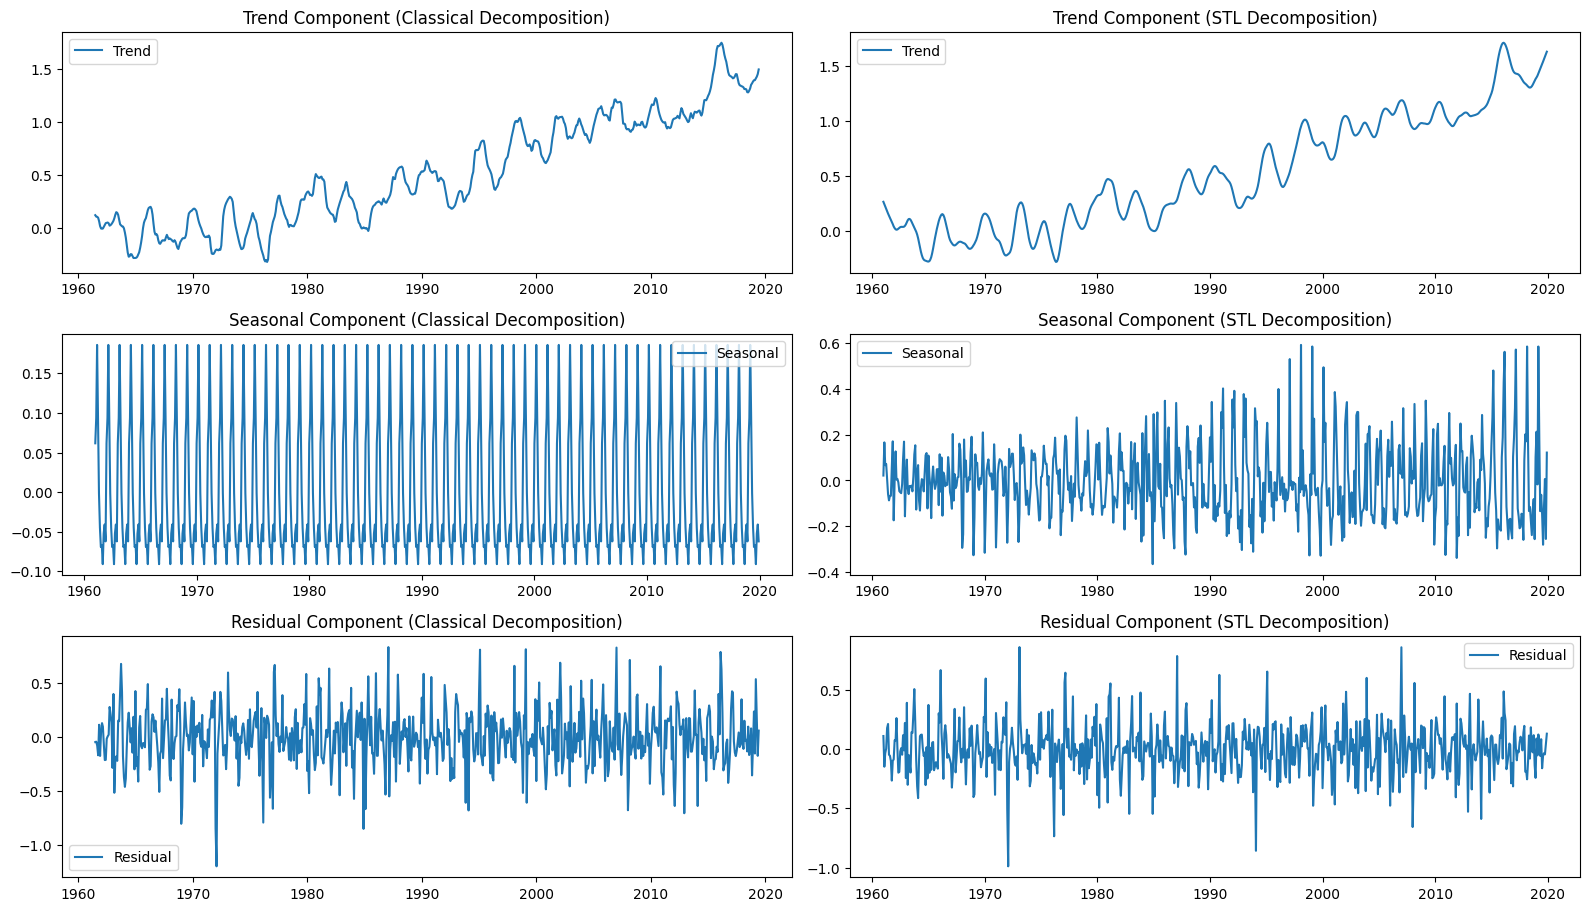

In [29]:
# Plotting
plt.figure(figsize=(16, 12))

# Classical Decomposition Components
plt.subplot(4, 2, 1)
plt.plot(df.index, classical_trend, label='Trend')
plt.title('Trend Component (Classical Decomposition)')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(df.index, classical_seasonal, label='Seasonal')
plt.title('Seasonal Component (Classical Decomposition)')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(df.index, classical_residual, label='Residual')
plt.title('Residual Component (Classical Decomposition)')
plt.legend()

# STL Decomposition Components
plt.subplot(4, 2, 2)
plt.plot(df.index, stl_trend, label='Trend')
plt.title('Trend Component (STL Decomposition)')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(df.index, stl_seasonal, label='Seasonal')
plt.title('Seasonal Component (STL Decomposition)')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(df.index, stl_residual, label='Residual')
plt.title('Residual Component (STL Decomposition)')
plt.legend()

plt.tight_layout()
plt.show()

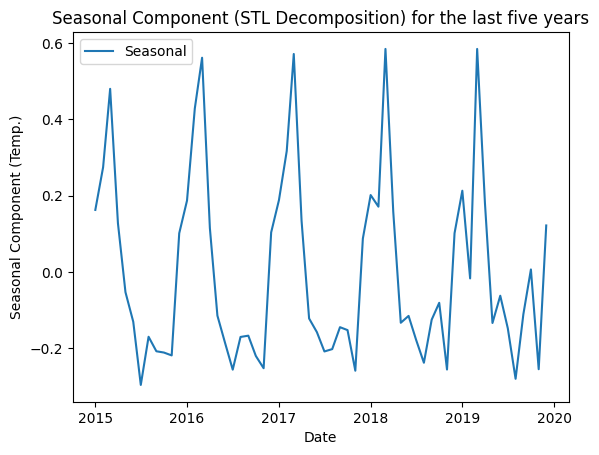

In [30]:
# Plot the seasonal component (STL Decomposition) for the last five years
plt.plot(df.index[-60:], stl_seasonal[-60:], label='Seasonal')
plt.title('Seasonal Component (STL Decomposition) for the last five years')
plt.xlabel('Date')
plt.ylabel('Seasonal Component (Temp.)')
plt.legend()
plt.show()

### ADF Test

__Purpose__

This method below checks the stationarity of data by performing ADF test

__Result__

The initial data is not stationary because it has the p-value more than 0.05 for ADF test.

In [31]:
def check_stationarity_adf(data):
    # Perform ADF test
    adf_result = adfuller(data)
    adf_statistic = adf_result[0]
    adf_p_value = adf_result[1]

    # Print results
    print("ADF Test:")
    print("ADF Statistic:", adf_statistic)
    print("p-value:", adf_p_value)
    if adf_p_value < 0.05:
        print("ADF Test Result: Data is stationary\n")
    else:
        print("ADF Test Result: Data is non-stationary\n")

In [32]:
check_stationarity_adf(df.World)

ADF Test:
ADF Statistic: -1.6849230215256215
p-value: 0.43889685163738834
ADF Test Result: Data is non-stationary



### KPSS Test

__Purpose__
This method below checks the stationarity of data by performing KPSS test

__Result__
The initial data is not stationary because it has the p-value less than 0.05 for KPSS test.

In [33]:
from statsmodels.tsa.stattools import kpss

def check_stationarity_kpss(data):
    # Perform KPSS test
    kpss_result = kpss(data, regression='c', nlags="auto")
    kpss_statistic = kpss_result[0]
    kpss_p_value = kpss_result[1]
    kpss_critical_values = kpss_result[3]

    # Print results
    print("KPSS Test:")
    print("KPSS Statistic:", kpss_statistic)
    print("p-value:", kpss_p_value)
    print("Critical Values:")
    for key, value in kpss_critical_values.items():
        print(f"   {key} : {value}")

    if kpss_p_value < 0.05:
        print("KPSS Test Result: Data is non-stationary\n")
    else:
        print("KPSS Test Result: Data is stationary\n")

# Example usage:
# check_stationarity_kpss(your_data_series)


In [34]:
check_stationarity_kpss(df.World)

KPSS Test:
KPSS Statistic: 3.8583917382227457
p-value: 0.01
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test Result: Data is non-stationary



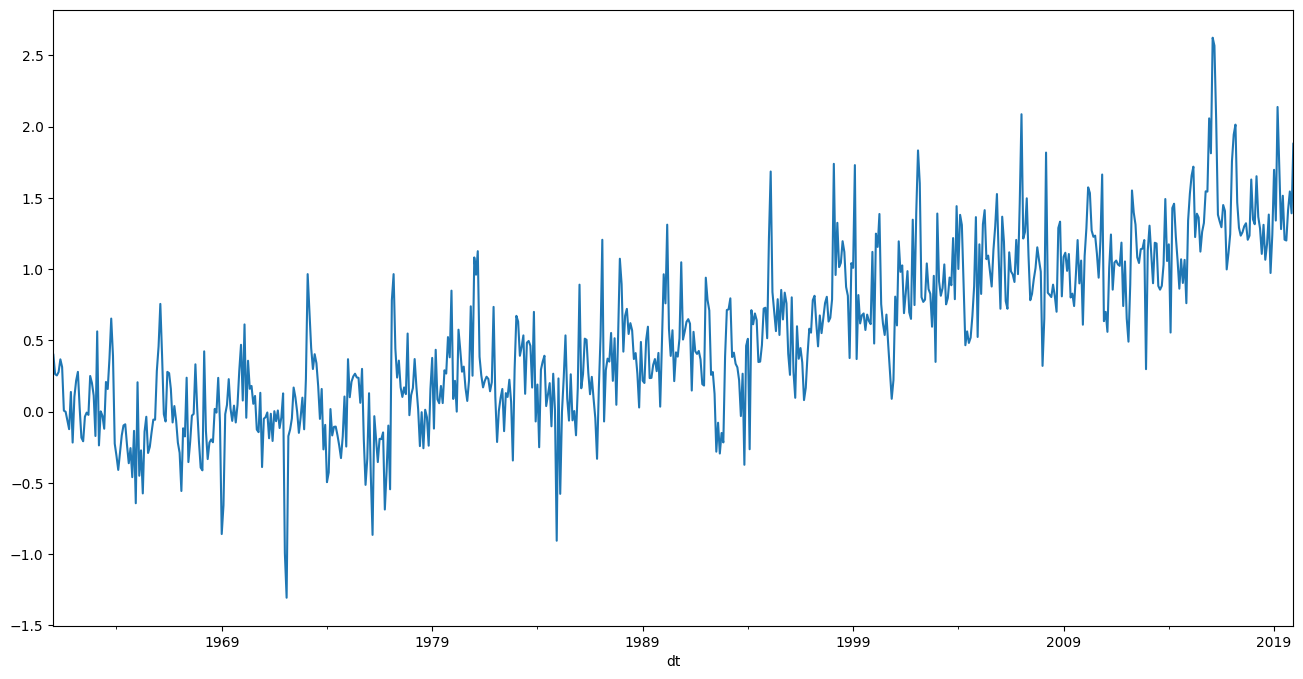

In [35]:
df.World.plot(figsize=(16, 8));

### Differencing

__Purpose__

The purpose of differencing is to make the data stationary and enable the prediction implementation. 

__Result__

After the differencing, the data becomes stationary, so it is successful.

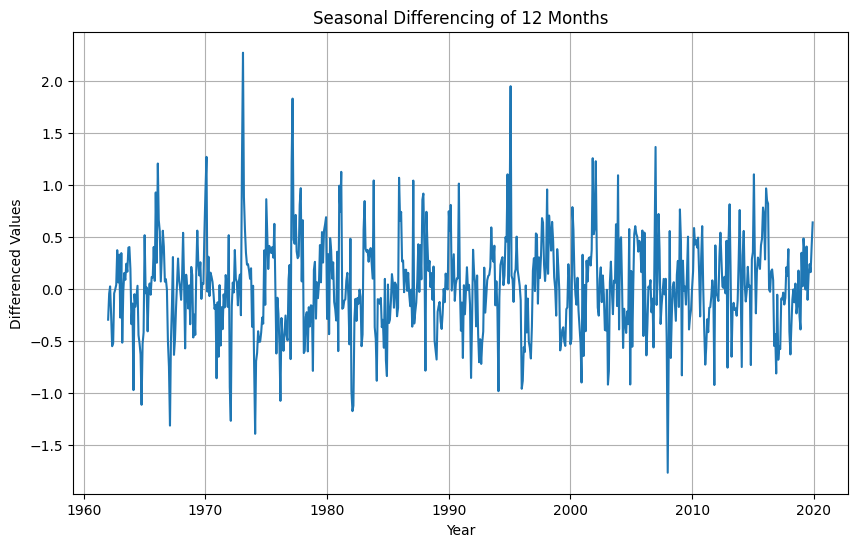

In [36]:
# Compute seasonal differencing of 12 months for the 'LandAverageTemperature' column
seasonal_diff = df.World.diff(12)

# Plot the differenced column
plt.figure(figsize=(10, 6))
plt.plot(seasonal_diff)
plt.title('Seasonal Differencing of 12 Months')
plt.xlabel('Year')
plt.ylabel('Differenced Values')
plt.grid(True)
plt.show()

In [37]:
check_stationarity_adf(seasonal_diff.dropna())

ADF Test:
ADF Statistic: -9.124769377436934
p-value: 3.1351859009430827e-15
ADF Test Result: Data is stationary



In [38]:
check_stationarity_kpss(seasonal_diff.dropna())

KPSS Test:
KPSS Statistic: 0.046779679427558424
p-value: 0.1
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test Result: Data is stationary



In [39]:
# Compute the absolute minimum value of the seasonal differenced data
add_value = round(abs(seasonal_diff.min()))

# Print the value to be subtracted after developing the model
print(f"This value has to be subtracted after developing our model = {add_value}")

# Add the absolute minimum value to the seasonal differenced data
seasonal_diff += add_value

This value has to be subtracted after developing our model = 2


In [40]:
class TSMean:
    def __init__(self, series):
        """
        Initialize TSMean with the given time series.

        Parameters:
        series (pandas Series): Time series data.
        """
        # Calculate the mean of the series
        self.mean = series.mean()

    def forecast(self, steps):
        """
        Generate forecasts using the mean value.

        Parameters:
        steps (int): Number of steps to forecast.

        Returns:
        list: List of forecasted values.
        """
        # Return a list containing the mean value repeated for the specified number of steps
        return [self.mean] * steps
    
class TSNaive:
    def __init__(self, series):
        """
        Initialize TSNaive with the given time series.

        Parameters:
        series (pandas Series): Time series data.
        """
        # Store the last observed value of the series
        self.last_value = series.iloc[-1]

    def fit(self):
        """
        Fit the model (no action needed for naive method).

        Returns:
        self: Returns self.
        """
        return self

    def forecast(self, steps):
        """
        Generate forecasts using the last observed value.

        Parameters:
        steps (int): Number of steps to forecast.

        Returns:
        list: List of forecasted values.
        """
        # Return a list containing the last observed value repeated for the specified number of steps
        return [self.last_value] * steps
    
class TSNaiveSeasonal:
    def __init__(self, series, period):
        """
        Initialize TSNaiveSeasonal with the given time series and seasonal period.

        Parameters:
        series (pandas Series): Time series data.
        period (int): Seasonal period of the time series.
        """
        # Store the seasonal period and values of the series
        self.period = period
        self.values = series.values

    def forecast(self, steps):
        """
        Generate seasonal naive forecasts.

        Parameters:
        steps (int): Number of steps to forecast.

        Returns:
        list: List of forecasted values.
        """
        # Generate forecasts by repeating the last observed value from the corresponding season
        seasonal_forecast = []
        for i in range(steps):
            index = len(self.values) - (i % self.period) - 1
            seasonal_forecast.append(self.values[index])
        return seasonal_forecast[::-1]
    
class TSDrift:
    def __init__(self, series):
        """
        Initialize TSDrift with the given time series.

        Parameters:
        series (pandas Series): Time series data.
        """
        # Calculate the linear regression parameters
        self.x_start = 0
        self.x_end = len(series) - 1
        self.y_start = series.iloc[0]
        self.y_end = series.iloc[-1]
        self.slope = (self.y_end - self.y_start) / (self.x_end - self.x_start)
        self.intercept = self.y_start - self.slope * self.x_start

    def forecast(self, steps):
        """
        Generate forecasts using the linear regression (drift) method.

        Parameters:
        steps (int): Number of steps to forecast.

        Returns:
        list: List of forecasted values.
        """
        # Generate forecasts by extending the linear regression line into the future
        forecast_values = [self.intercept + self.slope * (self.x_end + i) for i in range(1, steps + 1)]
        return forecast_values

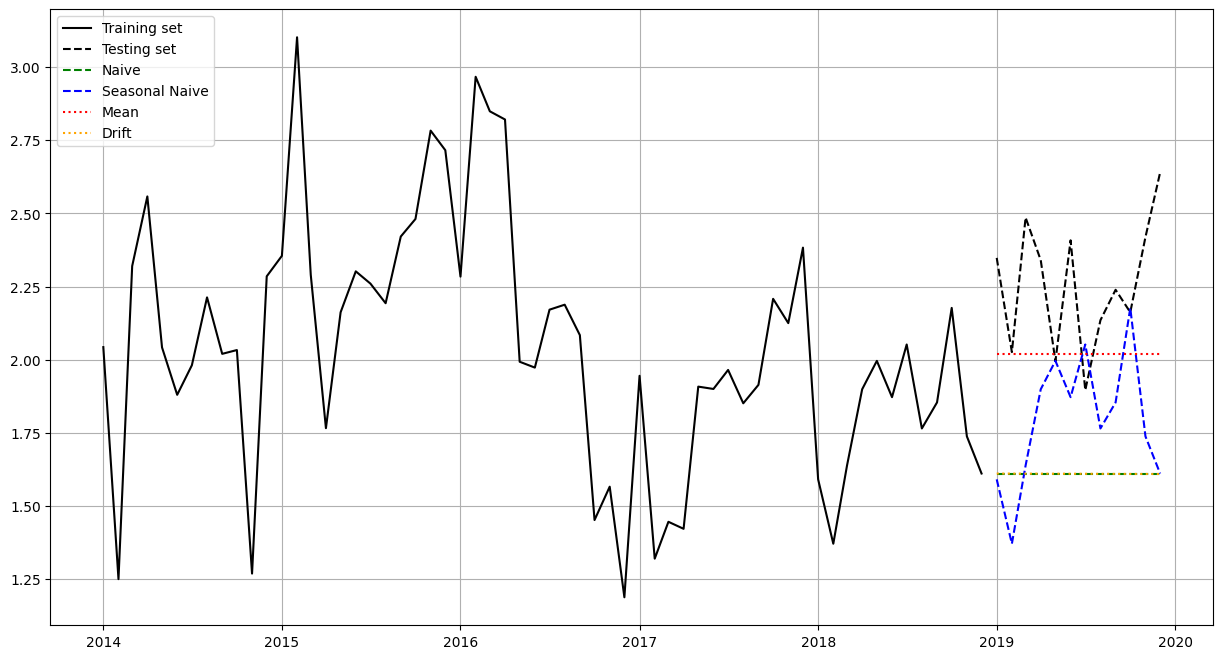

In [41]:
Train = seasonal_diff.dropna()[:-12]
Test = seasonal_diff.dropna()[-12:]

forecast_mean = np.array([Train.mean()] * 12)

forecast_naive = np.array([Train.iloc[-1]] * 12)

forecast_seasonal = Train[-12:].values

last_value = Train.iloc[-1]
slope = (last_value - Train.iloc[0]) / (len(Train) - 1)
forecast_drift = np.array([last_value + slope * i for i in range(1, 13)])

test_index = Test.index.to_numpy()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(Train[-60:], 'k', label='Training set')
ax.plot(Test, 'k', linestyle='--', label='Testing set')
ax.plot(test_index, forecast_naive, color='green', label='Naive', linestyle='--')
ax.plot(test_index, forecast_seasonal, color='blue', label='Seasonal Naive', linestyle='--')
ax.plot(test_index, forecast_mean, color='red', label='Mean', linestyle='dotted')
ax.plot(test_index, forecast_drift, color='orange', label='Drift', linestyle=':')
ax.legend(loc='upper left')
ax.grid()
plt.show()

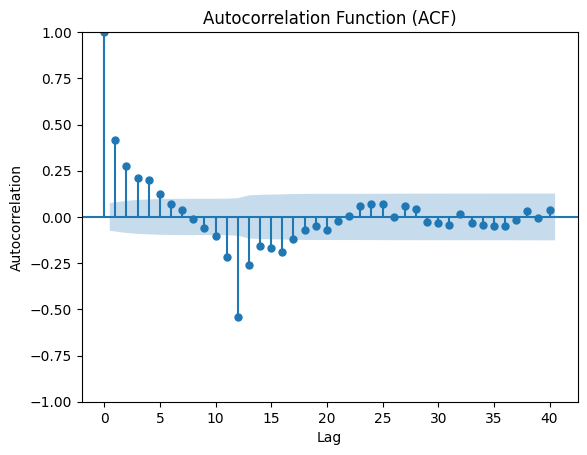

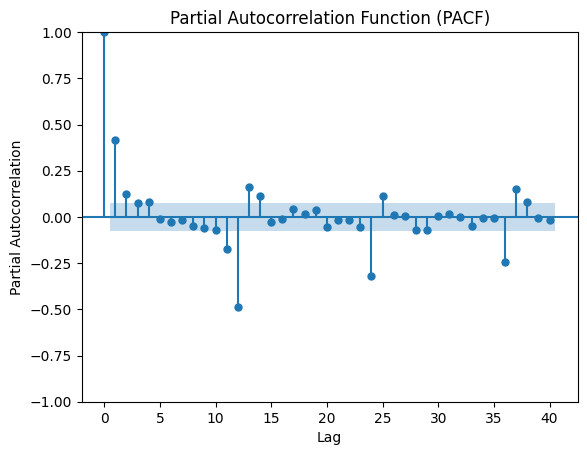

In [42]:
# Plot ACF
plot_acf(Train, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plot_pacf(Train, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [43]:
# Print information about the data
print('Observations: {}'.format(len(seasonal_diff)))
print('Training Observations: {}'.format(len(Train)))
print('Testing Observations: {}'.format(len(Test)))

Observations: 708
Training Observations: 684
Testing Observations: 12


In [44]:
# Calculate RMSE, MAE, MAPE for each model
def calculate_metrics(true_values, forecasted_values):
    rmse = np.sqrt(mean_squared_error(true_values, forecasted_values))
    mae = mean_absolute_error(true_values, forecasted_values)
    mape = np.mean(np.abs((true_values - forecasted_values) / true_values)) * 100
    return [rmse, mae, mape]

In [45]:
naive_metrics = calculate_metrics(Test, forecast_naive)
seasonal_metrics = calculate_metrics(Test, forecast_seasonal)
mean_metrics = calculate_metrics(Test, forecast_mean)
drift_metrics = calculate_metrics(Test, forecast_drift)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Naive', 'Seasonal Naive', 'Mean', 'Drift'],
    'RMSE': [naive_metrics[0], seasonal_metrics[0], mean_metrics[0], drift_metrics[0]],
    'MAE': [naive_metrics[1], seasonal_metrics[1], mean_metrics[1], drift_metrics[1]],
    'MAPE (%)': [naive_metrics[2], seasonal_metrics[2], mean_metrics[2], drift_metrics[2]]
})
results.set_index('Model', inplace=True)
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371


### Autoregression Model

__Purpose of the Result__


__Interpretation of the Result__


In [46]:
# Train autoregression model
model = AutoReg(Train, lags=25)  # Create an autoregression model with 25 lags
model_fit = model.fit()  # Fit the autoregression model to the training data
print('Coefficients: %s' % model_fit.params)  # Print the coefficients of the fitted model

Coefficients: const        1.884218
World.L1     0.323824
World.L2     0.129516
World.L3     0.015437
World.L4     0.066744
World.L5     0.057751
World.L6    -0.006050
World.L7     0.064515
World.L8    -0.006788
World.L9    -0.029747
World.L10    0.047050
World.L11   -0.035232
World.L12   -0.739246
World.L13    0.188397
World.L14    0.124055
World.L15   -0.032693
World.L16   -0.003173
World.L17    0.055898
World.L18    0.004281
World.L19    0.068912
World.L20   -0.025832
World.L21   -0.005645
World.L22    0.036938
World.L23    0.023107
World.L24   -0.369310
World.L25    0.116335
dtype: float64


In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  World   No. Observations:                  684
Model:                    AutoReg(25)   Log Likelihood                -199.260
Method:               Conditional MLE   S.D. of innovations              0.327
Date:                Wed, 10 Jul 2024   AIC                            452.520
Time:                        13:38:00   BIC                            573.770
Sample:                    02-01-1964   HQIC                           499.520
                         - 12-01-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8842      0.240      7.849      0.000       1.414       2.355
World.L1       0.3238      0.039      8.372      0.000       0.248       0.400
World.L2       0.1295      0.038      3.403      0.001       0.055       0.204
World.L3       0.0154      0.038      0.402      0.688      -0.060       0.091
World.L4       0.0667      0.038      1.740      0.082      -0.008       0.142
World.L5       0.0578      0.038      1.502      0.133      -0.018       0.133
World.L6      -0.0061      0.039     -0.157      0.875      -0.082       0.069
World.L7       0.0645      0.038      1.680      0.093      -0.011       0.140
World.L8      -0.0068      0.038     -0.176      0.860      -0.082       0.069
World.L9      -0.0297      0.038     -0.774      0.439      -0.105       0.046
World.L10      0.0471      0.038      1.223      0.221      -0.028       0.122
World.L11     -0.0352      0.039     -0.914      0.360      -0.111       0.040
World.L12     -0.7392      0.038    -19.354      0.000      -0.814      -0.664
World.L13      0.1884      0.047      3.994      0.000       0.096       0.281
World.L14      0.1241      0.038      3.255      0.001       0.049       0.199
World.L15     -0.0327      0.038     -0.850      0.395      -0.108       0.043
World.L16     -0.0032      0.038     -0.083      0.934      -0.078       0.072
World.L17      0.0559      0.038      1.457      0.145      -0.019       0.131
World.L18      0.0043      0.038      0.111      0.911      -0.071       0.080
World.L19      0.0689      0.038      1.798      0.072      -0.006       0.144
World.L20     -0.0258      0.038     -0.673      0.501      -0.101       0.049
World.L21     -0.0056      0.038     -0.147      0.883      -0.081       0.070
World.L22      0.0369      0.038      0.964      0.335      -0.038       0.112
World.L23      0.0231      0.038      0.601      0.548      -0.052       0.098
World.L24     -0.3693      0.038     -9.695      0.000      -0.444      -0.295
World.L25      0.1163      0.039      2.998      0.003       0.040       0.192
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0179           -0.1804j            1.0338           -0.4721
AR.2            -1.0179           +0.1804j            1.0338            0.4721
AR.3            -0.9763           -0.3613j            1.0410           -0.4436
AR.4            -0.9763           +0.3613j            1.0410            0.4436
AR.5            -0.8104           -0.6683j            1.0503           -0.3902
AR.6            -0.8104           +0.6683j            1.0503            0.3902
AR.7            -0.6806           -0.7807j            1.0357           -0.3641
AR.8            -0.6806           +0.7807j            1.0357            0.3641
AR

predicted=2.104841, expected=2.348000
predicted=2.655505, expected=2.026000
predicted=2.424076, expected=2.486000
predicted=2.278513, expected=2.340000
predicted=2.153370, expected=1.995000
predicted=2.237691, expected=2.408000
predicted=2.082947, expected=1.896000
predicted=2.315136, expected=2.135000
predicted=2.253129, expected=2.239000
predicted=1.914500, expected=2.162000
predicted=2.251815, expected=2.419000
predicted=2.256439, expected=2.640000


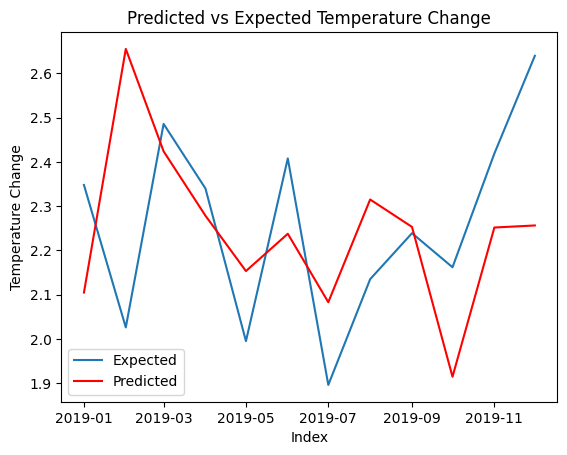

In [48]:
# Make predictions using the fitted model
predictions = model_fit.predict(start=len(Train), end=len(Train)+len(Test)-1, dynamic=False).values

# Print predicted and expected values
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], Test.iloc[i]))

# Plot predictions vs expected
plt.plot(Test.index, Test, label='Expected')
plt.plot(Test.index, predictions, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Temperature Change')
plt.title('Predicted vs Expected Temperature Change')
plt.legend();

In [49]:
# Calculate metrics for the predictions
metrics = calculate_metrics(Test, predictions)

# Create a DataFrame to hold the calculated metrics
metrics_df = pd.DataFrame([metrics], columns=['RMSE', 'MAE', 'MAPE (%)'])

# Add the calculated metrics as a row to the results DataFrame
results.loc['Autoregression'] = metrics_df.values[0]

In [50]:
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371
Autoregression,0.261570,0.208684,9.447758


In [51]:
# calculate residuals
# Predict values for the training set using the fitted autoregression model
# Start predicting from the 26th observation (lags = 25) to the end of the training set
predictions_train = model_fit.predict(start=25, end=len(Train), dynamic=False).values

# Extract the actual values of the training set starting from the 26th observation
Train_mod = Train[25:].values

# Calculate residuals by subtracting predicted values from actual values for each corresponding observation
train_resid = [Train_mod[i] - predictions_train[i] for i in range(len(Train_mod))]

In [52]:
model_ma = AutoReg(train_resid, lags=200) 
model_fit_ma = model_ma.fit()
print('Coefficients: %s' % model_fit_ma.params)

Coefficients: [ 2.34253627e-02 -6.05020624e-02 -1.05911455e-02 -2.01734165e-02
  8.16387540e-03  4.53290060e-02  2.76192222e-02  4.01675824e-03
 -7.82245334e-02  2.20402767e-03 -6.34410200e-03  2.62391305e-03
 -2.36485172e-01  5.14221970e-02  4.93403502e-02  3.58290887e-02
  2.21144243e-02  8.97701423e-03  2.79444173e-02 -4.29444912e-02
 -1.02892482e-02 -4.42551526e-02 -4.43465564e-02  1.06369201e-02
 -2.41924373e-01 -4.94722852e-02  4.23655726e-02  1.67756787e-02
 -1.75255609e-02 -9.18413810e-02 -1.97962771e-02 -2.55818221e-02
  8.31344399e-02  1.62349453e-03 -4.33500444e-02  6.57359918e-02
 -3.61615549e-01  3.94848580e-02  1.27704414e-02 -4.02200115e-02
  1.07190769e-03  2.99156936e-03  7.27577660e-02  7.57865409e-02
  1.73464033e-02  9.01124128e-02 -7.97937604e-02 -4.63811539e-02
 -1.90869550e-01 -4.55038007e-02 -4.73804785e-02 -6.04240047e-02
 -2.15704720e-03  5.33599838e-03  2.74341766e-02 -2.82370390e-03
  1.08204743e-02 -1.08829374e-02 -4.33780603e-02  3.45297566e-02
 -3.4006054

In [53]:
model_fit_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  659
Model:                   AutoReg(200)   Log Likelihood                   3.619
Method:               Conditional MLE   S.D. of innovations              0.240
Date:                Wed, 10 Jul 2024   AIC                            396.763
Time:                        13:38:01   BIC                           1230.831
Sample:                           200   HQIC                           725.231
                                  659                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.014      1.730      0.084      -0.003       0.050
y.L1          -0.0605      0.046     -1.302      0.193      -0.152       0.031
y.L2          -0.0106      0.047     -0.227      0.820      -0.102       0.081
y.L3          -0.0202      0.047     -0.432      0.665      -0.112       0.071
y.L4           0.0082      0.047      0.175      0.861      -0.083       0.100
y.L5           0.0453      0.046      0.975      0.329      -0.046       0.136
y.L6           0.0276      0.046      0.603      0.546      -0.062       0.117
y.L7           0.0040      0.046      0.088      0.930      -0.086       0.094
y.L8          -0.0782      0.046     -1.718      0.086      -0.167       0.011
y.L9           0.0022      0.046      0.048      0.961      -0.087       0.092
y.L10         -0.0063      0.045     -0.139      0.889      -0.095       0.083
y.L11          0.0026      0.045      0.058      0.954      -0.086       0.092
y.L12         -0.2365      0.045     -5.230      0.000      -0.325      -0.148
y.L13          0.0514      0.047      1.105      0.269      -0.040       0.143
y.L14          0.0493      0.046      1.063      0.288      -0.042       0.140
y.L15          0.0358      0.046      0.772      0.440      -0.055       0.127
y.L16          0.0221      0.046      0.476      0.634      -0.069       0.113
y.L17          0.0090      0.046      0.194      0.846      -0.082       0.100
y.L18          0.0279      0.046      0.605      0.545      -0.063       0.118
y.L19         -0.0429      0.046     -0.930      0.353      -0.133       0.048
y.L20         -0.0103      0.046     -0.224      0.823      -0.100       0.080
y.L21         -0.0443      0.046     -0.971      0.332      -0.134       0.045
y.L22         -0.0443      0.046     -0.974      0.330      -0.134       0.045
y.L23          0.0106      0.046      0.234      0.815      -0.079       0.100
y.L24         -0.2419      0.045     -5.333      0.000      -0.331      -0.153
y.L25         -0.0495      0.047     -1.059      0.290      -0.141       0.042
y.L26          0.0424      0.047      0.911      0.362      -0.049       0.134
y.L27          0.0168      0.047      0.359      0.719      -0.075       0.108
y.L28         -0.0175      0.047     -0.375      0.708      -0.109       0.074
y.L29         -0.0918      0.047     -1.972      0.049      -0.183      -0.001
y.L30         -0.0198      0.047     -0.424      0.672      -0.111       0.072
y.L31         -0.0256      0.047     -0.548      0.584      -0.117       0.066
y.L32          0.0831      0.047      1.780      0.075      -0.008       0.175
y.L33          0.0016      0.047      0.035      0.972      -0.090       0.093
y.L34         -0.0434      0.047     -0.922      0.357      -0.136       0.049
y.L35          0.0657      0.048      1.381      0.167      -0.028       0.159
y.L36         -0.3616      0.048     -7.596      0.000      -0.455      -0.268
y.L37          0.0395      0.051      0.774      0.439      -0.061       0.139
y.

predicted=-0.033392, expected=0.243159
predicted=-0.384014, expected=-0.629505
predicted=-0.014778, expected=0.061924
predicted=-0.224976, expected=0.061487
predicted=0.148460, expected=-0.158370
predicted=0.233809, expected=0.170309
predicted=0.268042, expected=-0.186947
predicted=0.165971, expected=-0.180136
predicted=0.111669, expected=-0.014129
predicted=-0.111567, expected=0.247500
predicted=0.539711, expected=0.167185
predicted=-0.420648, expected=0.383561


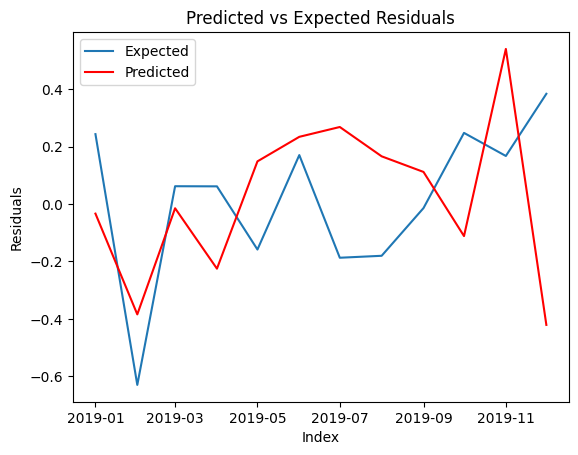

In [54]:
# Make predictions using the fitted model
predictions_ma = model_fit_ma.predict(start=len(train_resid), end=len(train_resid)+len(Test)-1, dynamic=False)

# Print predicted and expected values
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions_ma[i], Test.iloc[i]-predictions[i]))

# Calculate and print Root Mean Squared Error (RMSE) for the predictions
# rmse = sqrt(mean_squared_error(test.values, predictions_ma))
# print('Test RMSE: %.3f' % rmse)

# Plot predictions vs expected
plt.plot(Test.index, Test - predictions, label='Expected')
plt.plot(Test.index, predictions_ma, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Predicted vs Expected Residuals')
plt.legend();

In [55]:
predictions_sum = [x + y for x, y in zip(predictions, predictions_ma)]
# Calculate metrics for the predictions
metrics = calculate_metrics(Test, predictions_sum)

# Create a DataFrame to hold the calculated metrics
metrics_df = pd.DataFrame([metrics], columns=['RMSE', 'MAE', 'MAPE (%)'])

# Add the calculated metrics as a row to the results DataFrame
results.loc['AR+MA'] = metrics_df.values[0]

In [56]:
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371
Autoregression,0.261570,0.208684,9.447758
AR+MA,0.362854,0.309853,13.794744


### Predicted vs. Expected Temperature Using ARIMA

__Purpose of the Result__
This plot compares predicted temperatures using the ARIMA model with the actual observed temperatures.

__Interpretation of the Result__
The plot shows that the ARIMA model cannot accurately predict temperature trends, the prediction values are way below the actual values. The reasom behind this is that the original temperature change data might had trends and seasonality that ARIMA cannot appropriately remove through differencing. 

In [57]:
# Automatically search for the best ARIMA model parameters using auto_arima function
seed = 42
auto_arima_model = auto_arima(Train, start_p=1, start_q=1,
                              max_p=30, max_q=30, m=1,
                              seasonal=False,
                              d=None, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True,
                              random_state=seed)

# Print the best parameters found by auto_arima
print("Best parameters found by auto_arima:", auto_arima_model.order)

# Create an ARIMA model with the best parameters obtained from auto_arima
model_arima = ARIMA(Train, order=auto_arima_model.order)

# Fit the ARIMA model to the training data
arima_fit = model_arima.fit()

# Akaike Information Criterion (AIC) is a metric used to evaluate the goodness of fit of a statistical model while penalizing for the number of parameters in the model. 
# The lower the AIC value, the better the model is considered to be.
# "intercept" refers to an additional parameter in the model equation that represents a constant term or a baseline level. Including an intercept term allows the model to capture any systematic offset or bias in the data that is not explained by the autoregressive (AR), differencing (I), and moving average (MA) components.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=827.687, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2940.509, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=999.858, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2257.945, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=821.101, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1844.393, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1668.998, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=823.453, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=762.414, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=783.899, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=761.151, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=808.529, Time

### The Akaike Information Criterion (AIC):
is a measure of the relative quality of statistical models for a given set of data. It was developed by the Japanese statistician Hirotugu Akaike in 1973.

__Purpose:__
The primary purpose of the AIC is to balance the goodness of fit of a model with its simplicity or complexity. It provides a way to compare different models fitted to the same dataset, considering both the goodness of fit and the number of parameters used in the model.

__Calculation:__
The AIC is calculated using the formula:

$$
AIC = −2×ln(𝐿) + 2×𝑘
$$

Where:
- 𝐿: is the likelihood of the model given the data.
- 𝑘: is the number of parameters in the model.

__Interpretation:__
- Lower AIC values: Models with lower AIC values are considered to have better balance between goodness of fit and simplicity. They are preferred over models with higher AIC values.
- Higher AIC values: Models with higher AIC values are considered to be less parsimonious or overly complex, and they may overfit the data.

__Usage:__
- The AIC is commonly used for model selection, especially in cases where multiple models are fitted to the same dataset. The model with the lowest AIC value is usually selected as the preferred model.
- AIC can be used to compare different models fitted to the same dataset, allowing researchers to choose the most appropriate model based on both fit and complexity.

In [58]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  World   No. Observations:                  684
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -376.575
Date:                Wed, 10 Jul 2024   AIC                            761.151
Time:                        13:38:04   BIC                            779.262
Sample:                    01-01-1962   HQIC                           768.159
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0184      0.036     56.550      0.000       1.948       2.088
ar.L1          0.7157      0.061     11.815      0.000       0.597       0.834
ma.L1         -0.3743      0.072     -5.225      0.000      -0.515      -0.234
sigma2         0.1760      0.007     23.965      0.000       0.162       0.190
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                77.20
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.25
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted=1.846328, expected=2.348000
predicted=1.895246, expected=2.026000
predicted=1.930254, expected=2.486000
predicted=1.955308, expected=2.340000
predicted=1.973239, expected=1.995000
predicted=1.986071, expected=2.408000
predicted=1.995254, expected=1.896000
predicted=2.001826, expected=2.135000
predicted=2.006529, expected=2.239000
predicted=2.009895, expected=2.162000
predicted=2.012304, expected=2.419000
predicted=2.014028, expected=2.640000


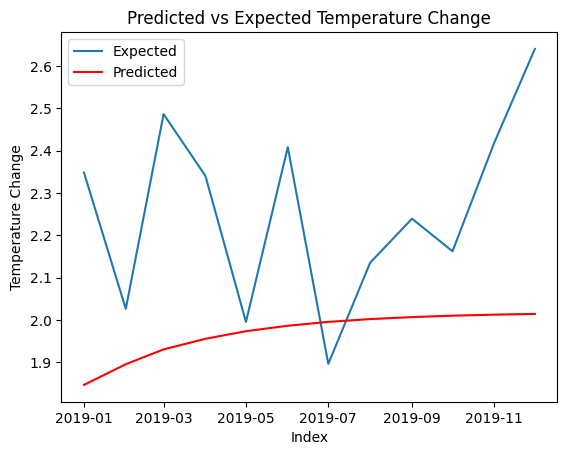

In [59]:
# Make predictions using the fitted model
predictions = arima_fit.predict(start=len(Train), end=len(Train)+len(Test)-1, dynamic=False).values

# Print predicted and expected values
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], Test.iloc[i]))

# Plot predictions vs expected
plt.plot(Test.index, Test, label='Expected')
plt.plot(Test.index, predictions, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Temperature Change')
plt.title('Predicted vs Expected Temperature Change')
plt.legend();

In [60]:
# Calculate metrics for the predictions
metrics = calculate_metrics(Test, predictions)

# Create a DataFrame to hold the calculated metrics
metrics_df = pd.DataFrame([metrics], columns=['RMSE', 'MAE', 'MAPE (%)'])

# Add the calculated metrics as a row to the results DataFrame
results.loc['ARIMA'] = metrics_df.values[0]

In [61]:
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371
Autoregression,0.261570,0.208684,9.447758
AR+MA,0.362854,0.309853,13.794744
ARIMA,0.361261,0.305519,12.886805


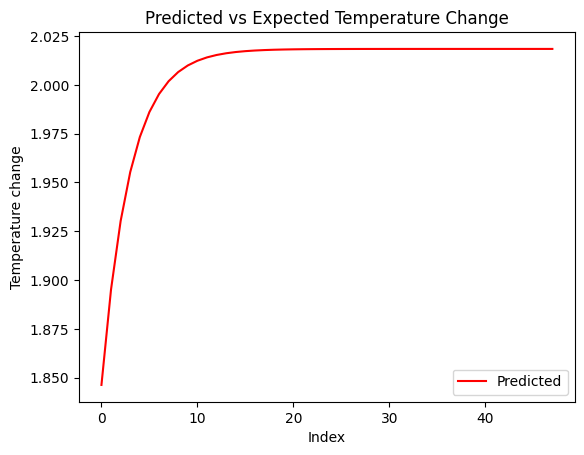

In [62]:
# Make predictions using the fitted model
predictions = arima_fit.predict(start=len(Train), end=len(Train)+len(Test)-1+36, dynamic=False).values

# Plot predictions vs expected
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Temperature change')
plt.title('Predicted vs Expected Temperature Change')
plt.legend();

### Seasonal Autoregressive Integrated Moving Average (SARIMA) model 
It is an extension of the Autoregressive Integrated Moving Average (ARIMA) model that includes __seasonality__. It is used for time series forecasting and can capture both __non-seasonal__ and __seasonal__ patterns in the data.

__Components of SARIMA Model:__
- Seasonal Autoregressive (SAR) terms: These terms capture the linear relationship between the observations at current and previous seasonal time points.

- Seasonal Integrated (SI) term: This term represents the seasonal differencing of the time series data to make it stationary.

- Seasonal Moving Average (SMA) terms: These terms capture the linear relationship between the error terms at current and previous seasonal time points.

- Autoregressive (AR) terms: These terms capture the linear relationship between the observations at current and previous non-seasonal time points.

- Integrated (I) term: This term represents the differencing of the time series data to make it stationary.

- Moving Average (MA) terms: These terms capture the linear relationship between the error terms at current and previous non-seasonal time points.

__Parameters of SARIMA Model SARIMA(p,d,q)(P,D,Q)[m]:__
- 𝑝: Number of autoregressive (AR) terms.
- 𝑑: Degree of differencing (non-seasonal).
- 𝑞: Number of moving average (MA) terms.
- 𝑃: Number of seasonal autoregressive (SAR) terms.
- 𝐷: Degree of seasonal differencing.
- 𝑄: Number of seasonal moving average (SMA) terms.
- 𝑚: Seasonal period.

_Advantages of SARIMA Model:_
- Can capture both non-seasonal and seasonal patterns in the data.
- Provides accurate forecasts for time series data with complex patterns.

__Limitations of SARIMA Model:__
- Requires careful identification of model parameters, which can be time-consuming.
- May not perform well for time series data with irregular or unpredictable patterns.

In summary, the SARIMA model is a powerful tool for time series forecasting, especially for data with clear seasonal patterns.

In [63]:
# fix the seed for randomness
seed = 42
np.random.seed(seed)

# Fit auto ARIMA model with seasonality
auto_aarima_model = auto_arima(Train, start_p=1, start_q=1,
                              max_p=30, max_q=30, m=12,  # Set m to the seasonal period
                              seasonal=True,  # Enable seasonal ARIMA
                              d=None, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True, 
                              random_state=seed)

# Print best parameters found
print("Order (p,d,q):", auto_aarima_model.order)
print("Seasonal Order (P,D,Q,m):", auto_aarima_model.seasonal_order)

# Fit SARIMA model with the best parameters
model_sarima = ARIMA(Train, order=auto_aarima_model.order, seasonal_order=auto_aarima_model.seasonal_order)
sarima_fit = model_sarima.fit()

# Print summary of the fitted model
print(sarima_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=903.766, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=555.629, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2940.509, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=774.321, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=472.271, Time=1.70 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=595.855, Time=0.86 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=453.005, Time=2.18 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=536.187, Time=0.63 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=453.177, Time

### Predicted vs. Expected Temperature Using SARIMA

__Purpose of the Result__
This plot compares predicted temperatures using the SARIMA model with the actual observed temperatures.

__Interpretation of the Result__
The plot shows that the SARIMA model better predict temperature trends than ARIMA model, though there may be discrepancies during certain periods. The reason behind this is that SARIMA can achieve stationarity better than ARIMA by handling seasonal differencing. 

predicted=2.164548, expected=2.348000
predicted=2.584114, expected=2.026000
predicted=2.379864, expected=2.486000
predicted=2.223996, expected=2.340000
predicted=2.007770, expected=1.995000
predicted=2.116094, expected=2.408000
predicted=1.975391, expected=1.896000
predicted=2.232159, expected=2.135000
predicted=2.153484, expected=2.239000
predicted=1.824516, expected=2.162000
predicted=2.176119, expected=2.419000
predicted=2.183921, expected=2.640000


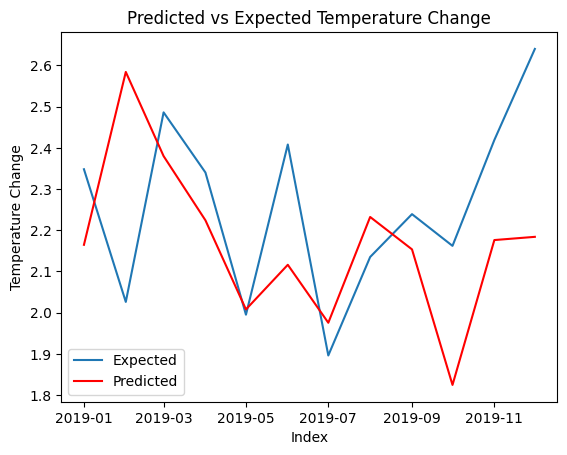

In [64]:
# Make predictions using the fitted model
predictions = sarima_fit.predict(start=len(Train), end=len(Train)+len(Test)-1, dynamic=False).values

# Print predicted and expected values
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], Test.iloc[i]))

# Plot predictions vs expected
plt.plot(Test.index, Test, label='Expected')
plt.plot(Test.index, predictions, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Temperature Change')
plt.title('Predicted vs Expected Temperature Change')
plt.legend();

In [65]:
# Calculate metrics for the predictions
metrics = calculate_metrics(Test, predictions)

# Create a DataFrame to hold the calculated metrics
metrics_df = pd.DataFrame([metrics], columns=['RMSE', 'MAE', 'MAPE (%)'])

# Add the calculated metrics as a row to the results DataFrame
results.loc['SARIMA'] = metrics_df.values[0]

In [66]:
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371
Autoregression,0.261570,0.208684,9.447758
AR+MA,0.362854,0.309853,13.794744
ARIMA,0.361261,0.305519,12.886805
SARIMA,0.267580,0.213908,9.402789


### Holt-Winters Seasonal Model 
The Holt-Winters Seasonal Model, also known as __Triple Exponential Smoothing__, is a time series forecasting method that extends the Holt's linear exponential smoothing method to handle seasonality in the data. It decomposes the time series into three components: __level, trend, and seasonal,__ and then forecasts future values by combining these components.

__Components of Holt-Winters Model:__
- Level (L): Represents the average value of the series over time. Updated using the previous level and the error correction term.
- Trend (T): Represents the rate of change of the series over time. Captures the slope or direction of the trend component.
- Seasonal (S): Represents the periodic fluctuations or seasonality in the data. Captures the repeating patterns at fixed intervals, such as daily, weekly, or yearly.

__Seasonal Decomposition:__
- The Holt-Winters Seasonal Model decomposes the time series into these three components using either additive or multiplicative decomposition. 
- Additive decomposition: assumes that the magnitude of seasonality remains constant over time.
- Multiplicative decomposition assumes that the magnitude of seasonality changes proportionally with the level of the series.

__Forecasting Process:__
1. Initialization: Initialize the level, trend, and seasonal components using simple methods such as averaging or linear regression.
2. Update Equations:__
- Update the level, trend, and seasonal components using exponential smoothing equations.
- The level is updated using a combination of the previous level and the error correction term.
- The trend is updated using a combination of the previous trend and the trend correction term.
- The seasonal component is updated using a combination of the previous seasonal component and the seasonal correction term.
3. Forecasting:
- The forecasted value is the sum (for additive decomposition) or the product (for multiplicative decomposition) of the level, trend, and seasonal components.


__Model Parameters (α, β, γ, m):__
- α, 𝛽, and 𝛾 are smoothing parameters controlling the weights assigned to the current observation, trend, and seasonal components, respectively.
- These parameters are typically chosen through optimization techniques such as grid search or cross-validation.
- Seasonal Period (m): Specifies the length of the seasonal cycle in the data. This parameter needs to be determined based on domain knowledge or through exploratory data analysis.

__Advantages:__
- Accurate forecasting of time series data with trend and seasonality.
- Adaptability to changes in the data over time.
- Interpretability of the model parameters, providing insights into underlying patterns.

__Limitations:__
- Assumes that the data is stationary or can be made stationary through differencing.
- Complexity in tuning model parameters and selecting the appropriate seasonal period.

In summary, the Holt-Winters Seasonal Model is a powerful method for time series forecasting, capable of capturing trend and seasonality in the data. By decomposing the time series into level, trend, and seasonal components, and then combining these components for forecasting, the model provides accurate forecasts and valuable insights into time series data.

### Predicted vs. Expected Temperature Using Holt_Winters

__Purpose of the Result__
This plot compares predicted temperatures using the Holt-Winters model with the actual observed temperatures.

__Interpretation of the Result__
The plot shows that the ARIMA model cannot accurately predict temperature trends, the prediction values are way below the actual values.

predicted=1.954205, expected=2.348000
predicted=1.818188, expected=2.026000
predicted=1.521184, expected=2.486000
predicted=2.056670, expected=2.340000
predicted=1.600208, expected=1.995000
predicted=2.179243, expected=2.408000
predicted=1.961285, expected=1.896000
predicted=2.214802, expected=2.135000
predicted=1.756802, expected=2.239000
predicted=1.959311, expected=2.162000
predicted=2.156819, expected=2.419000
predicted=2.099831, expected=2.640000


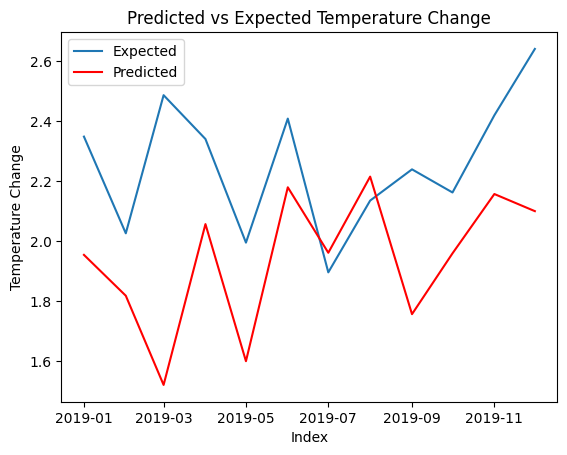

In [67]:
# Fix the seed for randomness
seed = 42
np.random.seed(seed)

# Fit Holt-Winters Seasonal Model
holt_winters_model = ExponentialSmoothing(
    Train,
    seasonal_periods=320,
    trend='add',        # 'add' for additive trend, can be 'mul' for multiplicative
    seasonal='add'      # 'add' for additive seasonality, can be 'mul' for multiplicative
).fit()

# Make predictions using the fitted model
predictions = holt_winters_model.forecast(len(Test))

# Print predicted and expected values
for i in range(len(predictions)):
    print(f'predicted={predictions.iloc[i]:.6f}, expected={Test.iloc[i]:.6f}')

# Plot predictions vs expected
plt.plot(Test.index, Test, label='Expected')
plt.plot(Test.index, predictions, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Temperature Change')
plt.title('Predicted vs Expected Temperature Change')
plt.legend()
plt.show()

In [68]:
# Calculate metrics for the predictions
metrics = calculate_metrics(Test, predictions)

# Create a DataFrame to hold the calculated metrics
metrics_df = pd.DataFrame([metrics], columns=['RMSE', 'MAE', 'MAPE (%)'])

# Add the calculated metrics as a row to the results DataFrame
results.loc['Holt_Winters'] = metrics_df.values[0]

In [69]:
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371
Autoregression,0.261570,0.208684,9.447758
AR+MA,0.362854,0.309853,13.794744
ARIMA,0.361261,0.305519,12.886805
SARIMA,0.267580,0.213908,9.402789
Holt_Winters,0.414563,0.342136,14.718971


In [70]:
from keras.layers import Dense, Input
from keras.models import Sequential, Model

In [71]:
# split a univariate sequence into samples (input and output)
def split_sequence(sequence, n_steps):
    X = [sequence[i:i+n_steps] for i in range(len(sequence) - n_steps)]
    y = [sequence[i+n_steps] for i in range(len(sequence) - n_steps)]
    return np.array(X), np.array(y)

In [72]:
# Define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# Choose a number of time steps
n_steps = 3
# Split into samples: Three time steps are used as input and one time step is used as output (to be predicted)
X, y = split_sequence(raw_seq, n_steps)
# Summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


## 1. Univariate MLP Models

In [73]:
# Define the model
model = Sequential()

# Add a dense (fully connected) layer (single hidden layer) with 100 neurons and ReLU activation function
# input_dim is set to n_steps, the number of input observations
model.add(Dense(100, activation='relu', input_dim=n_steps))

#Note: the model will view each time step as a separate feature instead of separate time steps.

# Add an output layer with a single neuron (single-step forecasting)
model.add(Dense(1))

# Compile the model using Adam optimizer and mean squared error (mse) loss function
model.compile(optimizer='adam', loss='mse')

In [74]:
# fit model
model.fit(X, y, epochs=1000, verbose=1)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1476.8535
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1350.8732
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1231.0297
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1117.7236
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1010.2713
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 908.6614
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 813.4108
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 724.2923
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 640.8503
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 563.4541
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 492.0067
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 426.5431
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 366.9075
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.9957
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━

In [75]:
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps))
yhat = model.predict(x_input, verbose=0)

In [76]:
print(yhat)

[[101.10998]]


In [77]:
X, y = split_sequence(df['World'].tolist(), 24)

In [78]:
X

array([[ 0.399,  0.263,  0.254, ...,  0.25 ,  0.201,  0.113],
       [ 0.263,  0.254,  0.278, ...,  0.201,  0.113, -0.171],
       [ 0.254,  0.278,  0.367, ...,  0.113, -0.171,  0.563],
       ...,
       [ 1.206,  1.235,  1.629, ...,  1.207,  1.201,  1.415],
       [ 1.235,  1.629,  1.349, ...,  1.201,  1.415,  1.545],
       [ 1.629,  1.349,  1.315, ...,  1.415,  1.545,  1.392]])

In [79]:
y

array([-1.710e-01,  5.630e-01, -2.370e-01,  2.000e-03, -2.900e-02,
       -1.200e-01,  2.080e-01,  1.590e-01,  3.740e-01,  6.530e-01,
        3.920e-01, -2.250e-01, -3.110e-01, -4.090e-01, -2.870e-01,
       -1.670e-01, -9.700e-02, -8.900e-02, -2.350e-01, -3.620e-01,
       -2.560e-01, -4.600e-01, -1.350e-01, -6.430e-01,  2.060e-01,
       -4.500e-01, -2.720e-01, -5.740e-01, -1.410e-01, -3.600e-02,
       -2.900e-01, -2.470e-01, -1.460e-01, -5.600e-02, -5.700e-02,
        2.850e-01,  4.580e-01,  7.560e-01,  3.910e-01, -1.800e-02,
       -6.900e-02,  2.790e-01,  2.700e-01,  1.590e-01, -7.600e-02,
        3.900e-02, -6.300e-02, -2.180e-01, -2.890e-01, -5.570e-01,
       -1.170e-01, -1.740e-01,  2.380e-01, -3.540e-01, -2.140e-01,
       -2.800e-02, -1.600e-02,  3.320e-01,  2.500e-02, -2.080e-01,
       -3.930e-01, -4.120e-01,  4.230e-01, -1.370e-01, -3.330e-01,
       -2.170e-01, -1.950e-01, -2.150e-01,  1.900e-02, -7.000e-03,
        2.370e-01, -7.500e-02, -8.590e-01, -6.580e-01, -1.800e

In [80]:
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)   # 60% training, 20% testing, and 20% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [81]:
# Set the random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Define the model
model_1 = Sequential()

# Add a dense (fully connected) layer (single hidden layer) with 100 neurons and ReLU activation function
# input_dim is set to n_steps, the number of input observations
model_1.add(Dense(100, activation='relu', input_dim=24))

#Note: the model will view each time step as a separate feature instead of separate time steps.

# Add an output layer with a single neuron (single-step forecasting)
model_1.add(Dense(1))

# Compile the model using Adam optimizer and mean squared error (mse) loss function
model_1.compile(optimizer='adam', loss='mse')

In [82]:
# fit model
history_1 = model_1.fit(X_train, y_train, epochs=2000, verbose=1, validation_data=(X_val, y_val))

Epoch 1/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5835 - val_loss: 0.2122
Epoch 2/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2175 - val_loss: 0.1215
Epoch 3/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 - val_loss: 0.1147
Epoch 4/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1271 - val_loss: 0.1124
Epoch 5/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1192 - val_loss: 0.1030
Epoch 6/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1100 - val_loss: 0.1013
Epoch 7/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1037 - val_loss: 0.0972
Epoch 8/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0997 - val_loss: 0.0971
Epoch 9/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0965 - val_loss: 0.0957
Epoch 10/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0945 - val_loss: 0.0959
Epoch 11/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0930 - val_loss: 0.0961
Epoch 12/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

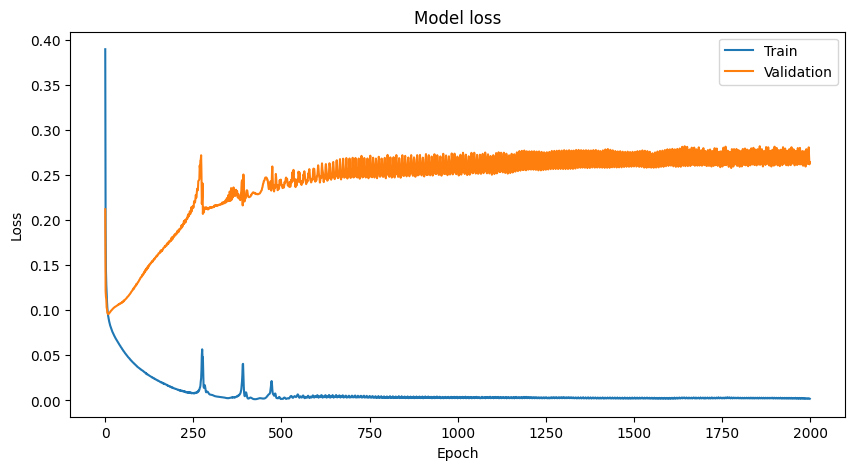

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


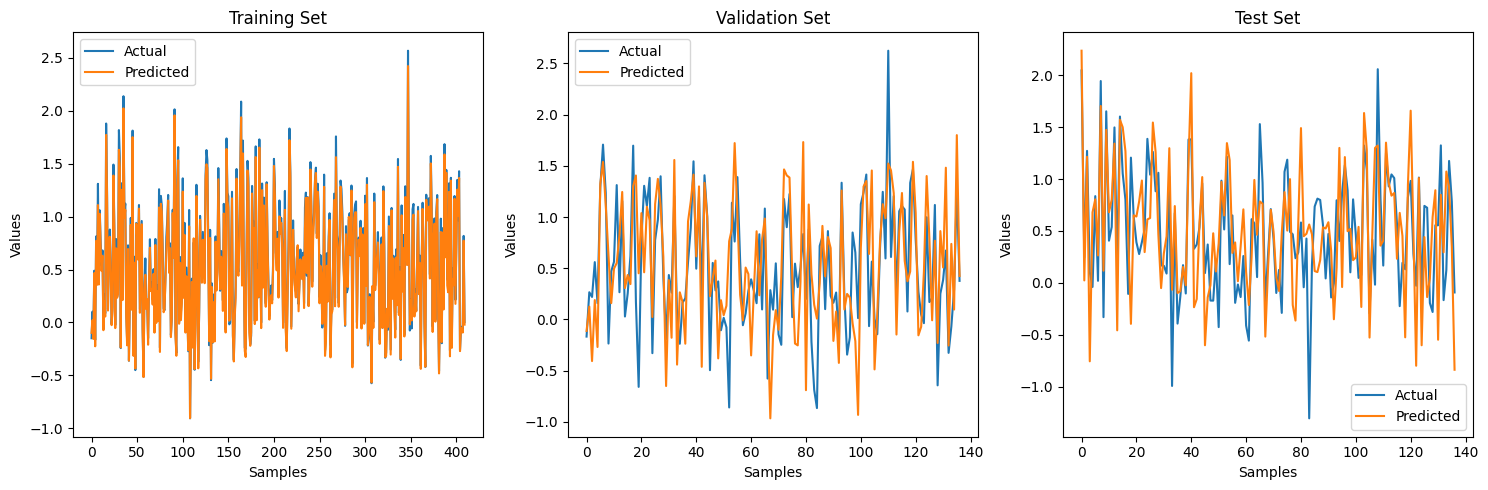

In [83]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict values
y_train_pred = model_1.predict(X_train)
y_val_pred = model_1.predict(X_val)
y_test_pred = model_1.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(15, 5))

# Training set
plt.subplot(1, 3, 1)
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Validation set
plt.subplot(1, 3, 2)
plt.plot(y_val, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.title('Validation Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Test set
plt.subplot(1, 3, 3)
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Test Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
from keras.callbacks import EarlyStopping

Epoch 1/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5606 - val_loss: 0.2866
Epoch 2/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2320 - val_loss: 0.1431
Epoch 3/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1495 - val_loss: 0.1365
Epoch 4/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1297 - val_loss: 0.1367
Epoch 5/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1259 - val_loss: 0.1226
Epoch 6/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1165 - val_loss: 0.1204
Epoch 7/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1130 - val_loss: 0.1137
Epoch 8/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1078 - val_loss: 0.1114
Epoch 9/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1042 - val_loss: 0.1083
Epoch 10/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1007 - val_loss: 0.1062
Epoch 11/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0980 - val_loss: 0.1044
Epoch 12/2000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

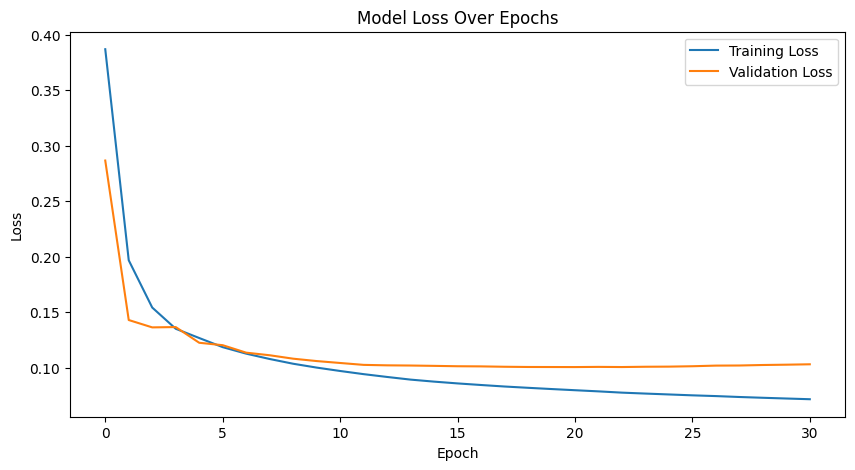

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


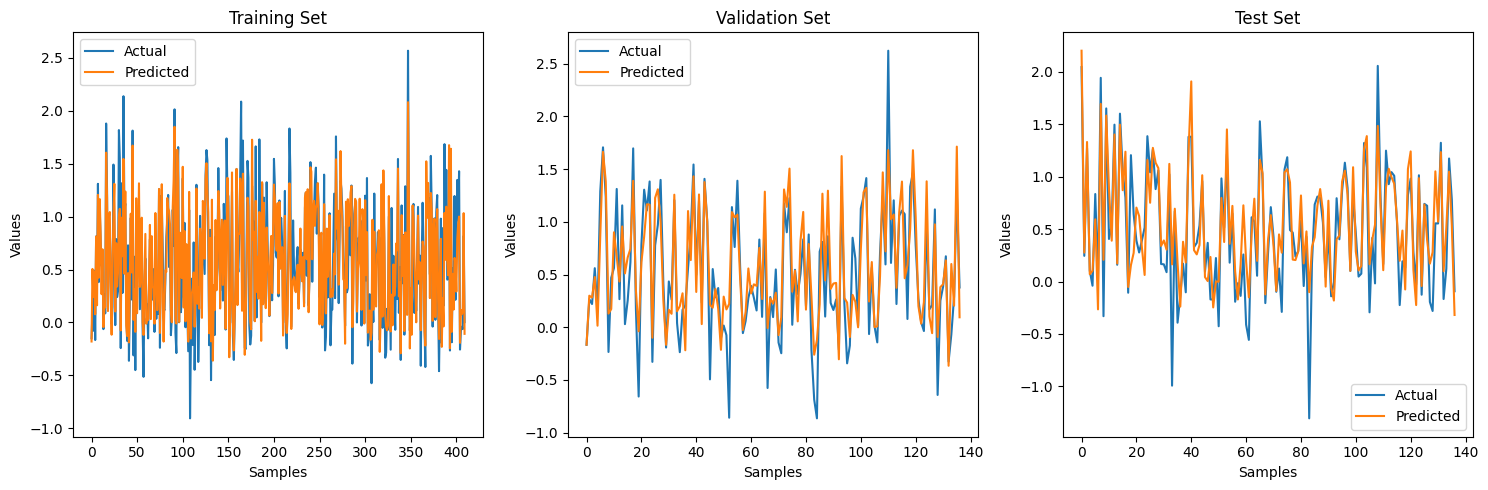

In [85]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the model
model_2 = Sequential()

# Add a dense (fully connected) layer (single hidden layer) with 100 neurons and ReLU activation function
# input_dim is set to n_steps, the number of input observations
model_2.add(Dense(100, activation='relu', input_dim=24))

#Note: the model will view each time step as a separate feature instead of separate time steps.

# Add an output layer with a single neuron (single-step forecasting)
model_2.add(Dense(1))

# Compile the model using Adam optimizer and mean squared error (mse) loss function
model_2.compile(optimizer='adam', loss='mse')

# Fit the model with EarlyStopping
history_2 = model_2.fit(X_train, y_train, epochs=2000, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Predict values
y_train_pred = model_2.predict(X_train)
y_val_pred = model_2.predict(X_val)
y_test_pred = model_2.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(15, 5))

# Training set
plt.subplot(1, 3, 1)
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Validation set
plt.subplot(1, 3, 2)
plt.plot(y_val, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.title('Validation Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Test set
plt.subplot(1, 3, 3)
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Test Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
# Function to print MAE for training, validation, and testing sets
def print_mae(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    print(f'Test MAE: {test_mae}')

In [87]:
# Print the MAE for the training, validation, and testing sets
print_mae(model_1, X_train, y_train, X_val, y_val, X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Training MAE: 0.05466943599894279
Validation MAE: 0.4083178103068014
Test MAE: 0.41729895746620904


In [88]:
# Print the MAE for the training, validation, and testing sets
print_mae(model_2, X_train, y_train, X_val, y_val, X_test, y_test)
# Model 2 with less computational time and less epochs has small MAE for testing and validation

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
Training MAE: 0.20965916625405775
Validation MAE: 0.24766408088058237
Test MAE: 0.22398141744969424


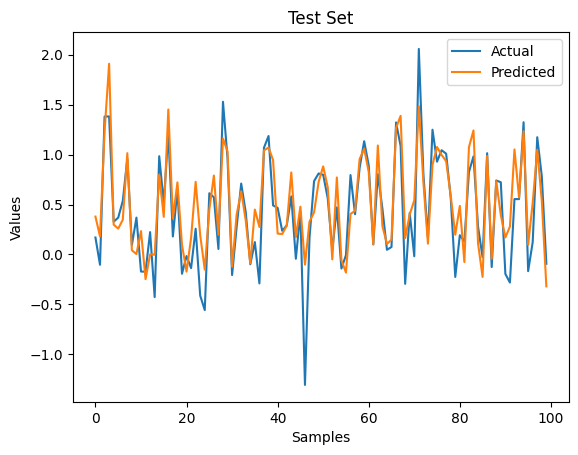

In [89]:
# Test set
plt.plot(y_test [-100:], label='Actual')
plt.plot(y_test_pred[-100:], label='Predicted')
plt.title('Test Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend();

In [90]:
# Calculate metrics for the predictions
metrics = calculate_metrics(Test, predictions)

# Create a DataFrame to hold the calculated metrics
metrics_df = pd.DataFrame([metrics], columns=['RMSE', 'MAE', 'MAPE (%)'])

# Add the calculated metrics as a row to the results DataFrame
results.loc['MLP'] = metrics_df.values[0]

In [91]:
results

,RMSE,MAE,MAPE (%)
Model,,,
Naive,0.680724,0.646833,28.004798
Seasonal Naive,0.579888,0.489500,20.867733
Mean,0.318755,0.262735,11.028375
Drift,0.681607,0.647728,28.044371
Autoregression,0.261570,0.208684,9.447758
AR+MA,0.362854,0.309853,13.794744
ARIMA,0.361261,0.305519,12.886805
SARIMA,0.267580,0.213908,9.402789
Holt_Winters,0.414563,0.342136,14.718971
